This notebook demonstrates the preprocessing steps from Lecture 2 applied to the
`Medicak_isurance.csv` dataset.

Sections:
1. Data loading & initial exploration
2. Missing data handling
3. Outlier detection
4. Data inconsistencies Detection
5. Normalization
6. Data splitting
7. Feature statistics
8. Summary & saving preprocessed data

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("MEDICAL INSURANCE COST PREDICTION DATA PREPROCESSING")
print("="*60)

MEDICAL INSURANCE COST PREDICTION DATA PREPROCESSING


# 1. Data Loading and Initial Exploration
 This cell loads the CSV into a pandas DataFrame and prints basic information
 including shape, the first few rows, data types, and a statistical summary.

In [37]:
# Load the data
df = pd.read_csv('medical_insurance.csv')

print("\n1. INITIAL DATA EXPLORATION")
print("-"*60)
print(f"Dataset Shape: {df.shape}")
print(f"Number of Records: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")
print("\nFirst few rows:")
print(df.head())
# Data types and info
print("\n2. DATA TYPES AND INFORMATION")
print("-"*60)
print(df.info())
print("\nData Types Summary:")
print(df.dtypes.value_counts())
# Statistical summary
print("\n3. STATISTICAL SUMMARY")
print("-"*60)
print(df.describe())


1. INITIAL DATA EXPLORATION
------------------------------------------------------------
Dataset Shape: (100000, 54)
Number of Records: 100000
Number of Features: 54

First few rows:
   person_id  age     sex   region urban_rural   income     education  \
0      75722   52  Female    North    Suburban  22700.0     Doctorate   
1      80185   79  Female    North       Urban  12800.0         No HS   
2      19865   68    Male    North       Rural  40700.0            HS   
3      76700   15    Male    North    Suburban  15600.0  Some College   
4      92992   53    Male  Central    Suburban  89600.0     Doctorate   

  marital_status employment_status  household_size  ...  liver_disease  \
0        Married           Retired               3  ...              0   
1        Married          Employed               3  ...              0   
2        Married           Retired               5  ...              0   
3        Married     Self-employed               5  ...              0   
4      

# 2. Data Cleaning — Missing Data


# This section checks for missing values, visualizes missingness, coerces
# non-numeric BMI entries to NaN, and demonstrates one imputation methods:
# mean, median, and KNN imputation. At the end we keep the KNN-imputed DataFrame
# for further processing (you can switch to a different method if desired).


2. HANDLING MISSING DATA
------------------------------------------------------------

Missing Values Summary:
              Missing Count  Percentage
alcohol_freq          30083      30.083


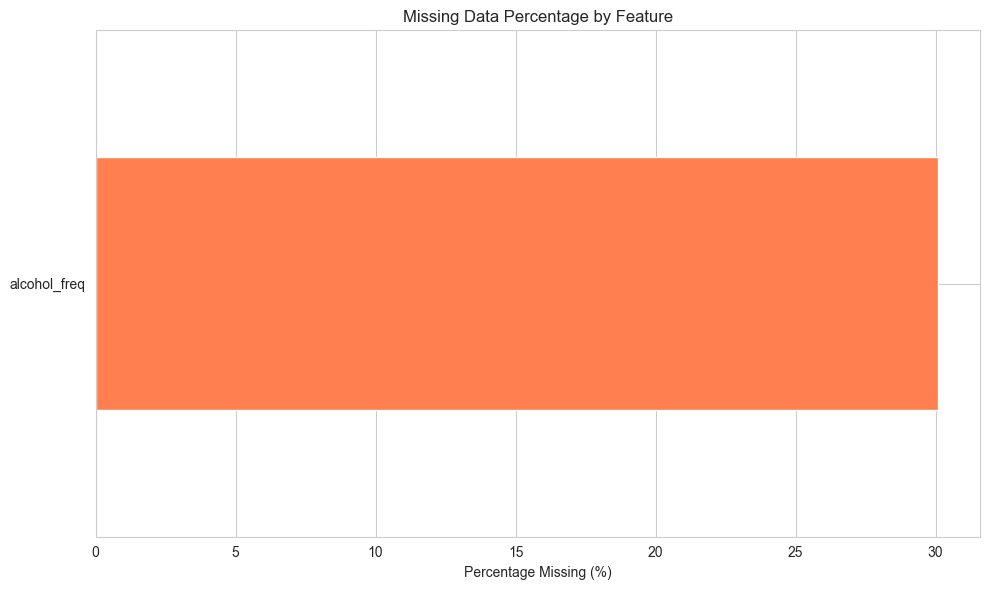

In [39]:
print("\n2. HANDLING MISSING DATA")
print("-"*60)

# Check for missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("\nMissing Values Summary:")
print(missing_df)

# Visualize missing data
plt.figure(figsize=(10, 6))
missing_df['Percentage'].plot(kind='barh', color='coral')
plt.xlabel('Percentage Missing (%)')
plt.title('Missing Data Percentage by Feature')
plt.tight_layout()
plt.show()


In [17]:
# Method 1: Simple Imputation - Mean for BMI
df_mean_impute = df.copy()
bmi_mean = df_mean_impute['bmi'].mean()
df_mean_impute['bmi'].fillna(bmi_mean, inplace=True)

print(f"\nMethod 1 - Mean Imputation:")
print(f"BMI Mean: {bmi_mean:.2f}")
print(f"Missing values after imputation: {df_mean_impute['bmi'].isnull().sum()}")


Method 1 - Mean Imputation:
BMI Mean: 28.89
Missing values after imputation: 0


In [18]:
# Method 2: Median Imputation
df_median_impute = df.copy()
bmi_median = df_median_impute['bmi'].median()
df_median_impute['bmi'].fillna(bmi_median, inplace=True)

print(f"\nMethod 2 - Median Imputation:")
print(f"BMI Median: {bmi_median:.2f}")
print(f"Missing values after imputation: {df_median_impute['bmi'].isnull().sum()}")


Method 2 - Median Imputation:
BMI Median: 28.10
Missing values after imputation: 0


In [29]:
# Method 3: KNN Imputation (Advanced)
print("\nMethod 3 - KNN Imputation:")

# Select numeric columns for KNN imputation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_knn = df.copy()

# Create a temporary dataframe with only numeric columns
numeric_data = df_knn[numeric_cols]

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(numeric_data)

# Replace the imputed columns
df_knn[numeric_cols] = imputed_data

print(f"Missing BMI values after KNN imputation: {df_knn['bmi'].isnull().sum()}")

# Compare imputation methods
comparison_df = pd.DataFrame({
    'Original (with NaN)': df['bmi'].describe(),
    'Mean Imputation': df_mean_impute['bmi'].describe(),
    'Median Imputation': df_median_impute['bmi'].describe(),
    'KNN Imputation': df_knn['bmi'].describe()
})
print("\nComparison of Imputation Methods:")
print(comparison_df)


Method 3 - KNN Imputation:
Missing BMI values after KNN imputation: 0

Comparison of Imputation Methods:
       Original (with NaN)  Mean Imputation  Median Imputation  KNN Imputation
count          4909.000000      5110.000000        5110.000000     5110.000000
mean             28.893237        28.893237          28.862035       28.933049
std               7.854067         7.698018           7.699562        7.740320
min              10.300000        10.300000          10.300000       10.300000
25%              23.500000        23.800000          23.800000       23.700000
50%              28.100000        28.400000          28.100000       28.200000
75%              33.100000        32.800000          32.800000       33.000000
max              97.600000        97.600000          97.600000       97.600000


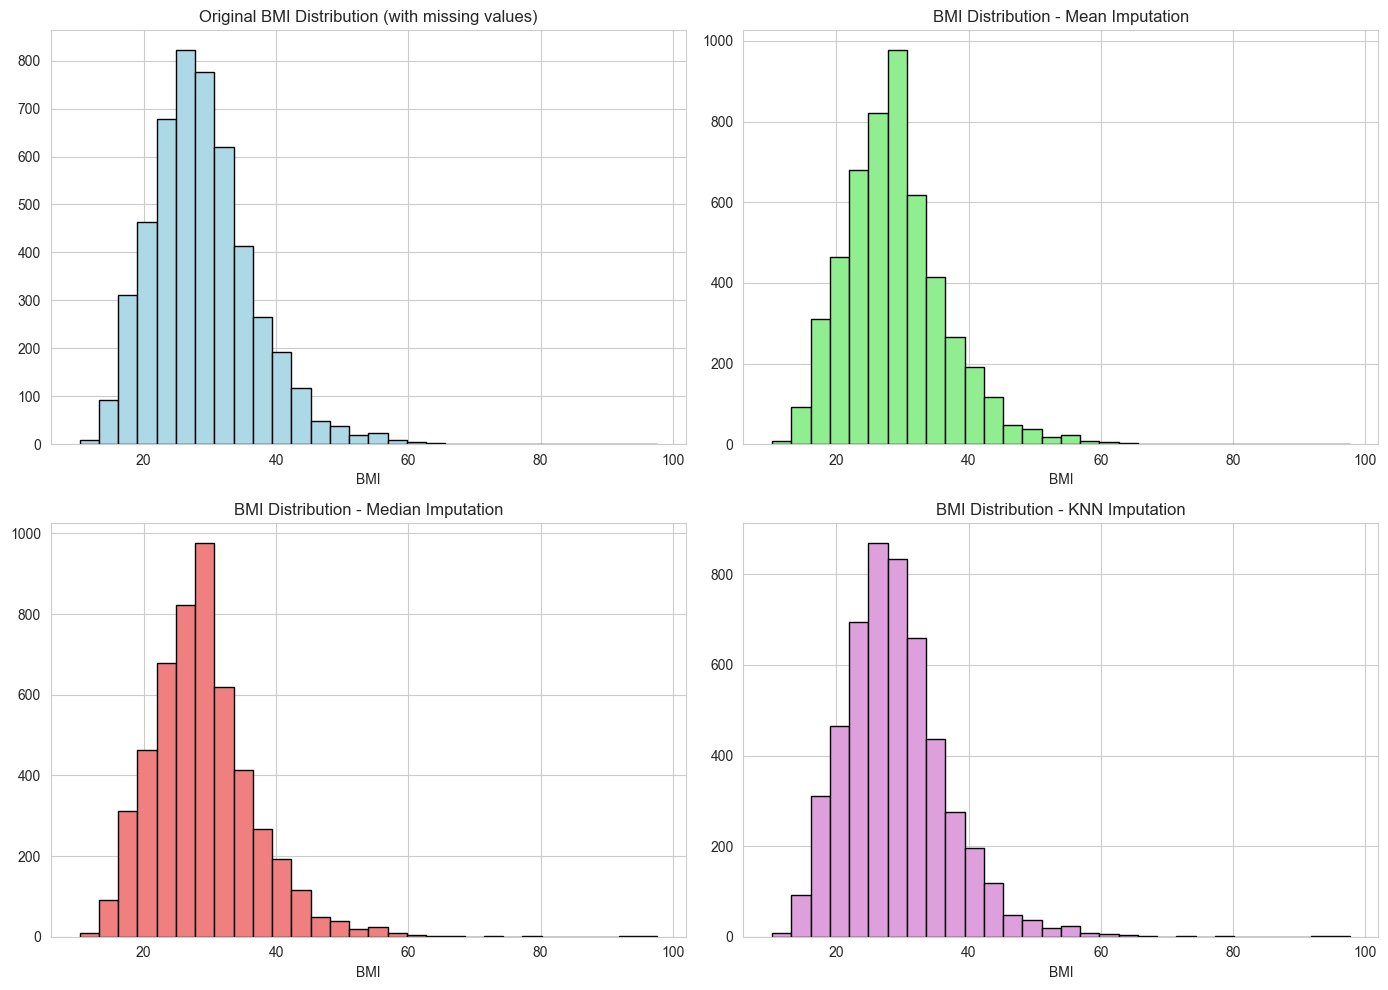

In [31]:
# Visualize imputation comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df['bmi'].hist(bins=30, ax=axes[0, 0], color='lightblue', edgecolor='black')
axes[0, 0].set_title('Original BMI Distribution (with missing values)')
axes[0, 0].set_xlabel('BMI')

df_mean_impute['bmi'].hist(bins=30, ax=axes[0, 1], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('BMI Distribution - Mean Imputation')
axes[0, 1].set_xlabel('BMI')

df_median_impute['bmi'].hist(bins=30, ax=axes[1, 0], color='lightcoral', edgecolor='black')
axes[1, 0].set_title('BMI Distribution - Median Imputation')
axes[1, 0].set_xlabel('BMI')

df_knn['bmi'].hist(bins=30, ax=axes[1, 1], color='plum', edgecolor='black')
axes[1, 1].set_title('BMI Distribution - KNN Imputation')
axes[1, 1].set_xlabel('BMI')

plt.tight_layout()
plt.show()

# Use KNN imputed data for further analysis
df = df_knn.copy()

# 3. Outlier Detection

 This section demonstrates the z-score method for detecting outliers

In [ ]:
print("\n3. OUTLIER DETECTION USING Z-SCORE METHOD")
print("-"*60)   
# Function to detect outliers using Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    z_scores = np.abs((data[column] - mean) / std)
    outliers = data[z_scores > threshold]
    return outliers

print("\nZ-SCORE METHOD (threshold=3):")
print("-"*40)
numeric_columns = ['age', 'avg_glucose_level', 'bmi']
for col in numeric_columns:
    outliers_z = detect_outliers_zscore(df, col)
    print(f"{col}: {len(outliers_z)} outliers ({len(outliers_z)/len(df)*100:.2f}%)")


5. OUTLIER DETECTION AND HANDLING
------------------------------------------------------------

Z-SCORE METHOD (threshold=3):
----------------------------------------
age: 0 outliers (0.00%)
avg_glucose_level: 49 outliers (0.96%)
bmi: 59 outliers (1.15%)


# 4. Data Inconsistencies Detection

 This section uses categorical columns for  Data Inconsistencies Detection

In [ ]:
print("\n4. DETECTING DATA INCONSISTENCIES")
print("-"*60)

# Check categorical columns for inconsistencies
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Unique values: {df[col].nunique()}")


6. DETECTING DATA INCONSISTENCIES
------------------------------------------------------------

gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Unique values: 3

ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
Unique values: 2

work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
Unique values: 5

Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
Unique values: 2

smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
Unique values: 4
